In [85]:
import matplotlib.pyplot as plt
import os
import glob
import numpy as np
import astropy.units as u
import random
import pandas as pd
import copy
import json
import numba
import math
import pickle

from textwrap import fill
from astropy.table import Table, vstack
from astropy.coordinates import SkyCoord
from astropy.io import fits
from astropy.coordinates import search_around_sky
from matplotlib.patches import Rectangle
from astropy.visualization import simple_norm
from astropy.wcs import WCS
from sklearn.model_selection import train_test_split
import matplotlib.colors as colors
from astropy.coordinates import angular_separation
import astropy.units as u
from astropy.table import join
from collections import Counter


from Constantes import SELECTED_COLUMNS_Xamin, SELECTED_COLUMNS_input_clusters, SELECTED_COLUMNS_input_AGN
from Constantes import VOCAB_SIZE, PAD_TOKEN, SEP_TOKEN, CLS_TOKEN, SEP_AMAS, SEP_AGN, NOMBRE_TOKENS_SPECIAUX
from Constantes import BATCH_SIZE, D_MODEL, NUM_HEADS, NUM_LAYERS, name_dir
from Constantes import name_dir

In [86]:
X_test  = np.loadtxt(f'/local/home/sh275430/Documents/TransformerSurFenestrons/results/{name_dir}/X_test.txt', dtype=int)
print(f"Nombre de sequences de test: {len(X_test)}")
print(f"len(gen_seq[0]) = {len(X_test[0])}")

Nombre de sequences de test: 5512
len(gen_seq[0]) = 24


In [87]:
with open(f'/local/home/sh275430/Documents/TransformerSurFenestrons/results/{name_dir}/generated_seq_by_imperator_test_full.pkl', 'rb') as f:
    gen_seq = pickle.load(f)

gen_seq = np.array(gen_seq)
print(f"Nombre de sequences de test: {len(gen_seq)}")
print(f"len(gen_seq[0]) = {len(gen_seq[0])}\n")

Nombre de sequences de test: 5512
len(gen_seq[0]) = 24



/tmp/ipykernel_48879/2962736386.py:2: DeprecationWarning: numpy.core.numeric is deprecated and has been renamed to numpy._core.numeric. The numpy._core namespace contains private NumPy internals and its use is discouraged, as NumPy internals can change without warning in any release. In practice, most real-world usage of numpy.core is to access functionality in the public NumPy API. If that is the case, use the public NumPy API. If not, you are using NumPy internals. If you would still like to access an internal attribute, use numpy._core.numeric._frombuffer.
  gen_seq = pickle.load(f)


In [88]:
#////////// Load Configuration /////////
with open(f"/local/home/sh275430/Documents/TransformerSurFenestrons/results/{name_dir}/constantes_du_modele.json", 'r') as f:
    config = json.load(f)

MAX_SOURCES  = config["MAX_SOURCES"]
MAX_CLUSTERS = config["MAX_CLUSTERS"]
MAX_AGN = config["MAX_AGN"]

print("┌───────────────────────────────┐")
print("│  MODEL CONFIGURATION          │")
print("├───────────────────────────────┤")
for key, value in config.items():
    print(f"│ {key.ljust(15)}: {str(value).rjust(10)}   │")
print("└───────────────────────────────┘")

┌───────────────────────────────┐
│  MODEL CONFIGURATION          │
├───────────────────────────────┤
│ VOCAB_SIZE     :       1029   │
│ PAD_TOKEN      :       1024   │
│ SEP_TOKEN      :       1025   │
│ CLS_TOKEN      :       1026   │
│ SEP_AMAS       :       1027   │
│ SEP_AGN        :       1028   │
│ NOMBRE_TOKENS_SPECIAUX:          5   │
│ MAX_SOURCES    :          2   │
│ MAX_CLUSTERS   :          2   │
│ MAX_AGN        :          3   │
└───────────────────────────────┘


In [89]:
num_fenetre = random.randint(0, len(gen_seq)-1)

print(X_test[num_fenetre])
print(gen_seq[num_fenetre])


[1026  536  434  496  497  335 1024 1024 1024 1024 1024 1027  528  528
 1024 1024 1028  521  520 1024 1024 1024 1024 1025]
[1026  536  434  496  497  335 1024 1024 1024 1024 1024 1027  335  335
 1024 1024 1028  335  335 1024 1024 1024 1024 1025]


In [90]:
def plot_sequence(sequence, num_fenetre, x_center=512, y_center=512):
    # Extraire les composants en supposant la structure:
    # [CLS_TOKEN, Xamin, SEP_AMAS, amas, SEP_AGN, AGN, SEP_TOKEN]
    sequence = sequence.tolist()

    # Indices des séparateurs
    try:
        sep_amas_idx = sequence.index(SEP_AMAS)
        sep_agn_idx = sequence.index(SEP_AGN)
        sep_end_idx = sequence.index(SEP_TOKEN)
    except ValueError:
        print("Séparateurs manquants dans la séquence.")
        return

    # Extraire les sous-parties
    xamin_part = sequence[1:sep_amas_idx]
    amas_part = sequence[sep_amas_idx + 1:sep_agn_idx]
    agn_part = sequence[sep_agn_idx + 1:sep_end_idx]

    plt.figure(figsize=(6, 6))

    # Plot Xamin
    compteur_xamin = 0
    for i in range(2, len(xamin_part), 5):
        x, y = xamin_part[i], xamin_part[i+1]
        if (x, y) != (1024, 1024):
            plt.scatter(x, y, marker='s', facecolors='none', edgecolors='lightseagreen',
                        s=100, linewidths=1.5, label='Input Clusters' if compteur_xamin==0 else "")
            compteur_xamin += 1

    compteur_output_agn, compteur_output_amas = 0, 0
    # Plot amas (paires [x,y]) - carrés rouges vides
    for i in range(0, len(amas_part), 2):
        x, y = amas_part[i], amas_part[i+1]
        if (x, y) != (1024, 1024):
            plt.scatter(x, y, marker='s', facecolors='none', edgecolors='red',
                      s=80, linewidths=1, label='Output Clusters' if compteur_output_amas==0 else "")
            compteur_output_amas += 1
        if (x == 1024 and y != 1024 ) or (y == 1024 and x != 1024 ):
            print("Bizarre coordonnees incompletes d'un amas")

    # Plot AGN (paires [x,y]) - étoiles rouges vides
    for i in range(0, len(agn_part), 2):
        x, y = agn_part[i], agn_part[i+1]
        if (x, y) != (1024, 1024):
            plt.scatter(x, y, marker='*', facecolors='none', edgecolors='red',
                      s=140, linewidths=1, label='Output AGN' if compteur_output_agn==0 else "")
            compteur_output_agn += 1
        if (x == 1024 and y != 1024 ) or (y == 1024 and x != 1024 ):
            print("Bizarre coordonnees incompletes d'un AGN")

    # Reste du code inchangé
    plt.axvline(x=0, color='black', linestyle='--')
    plt.axvline(x=1024, color='black', linestyle='--')
    plt.axhline(y=0, color='black', linestyle='--')
    plt.axhline(y=1024, color='black', linestyle='--')

    plt.xlim(-100, 1124)
    plt.ylim(-110, 1124)
    plt.grid(True)
    plt.legend()
    plt.title(f"Visualisation de la fenêtre {num_fenetre}")

    # Ajout d'un texte d'information
    info_text = (f"Input Xamin: {compteur_xamin}\n"
                 f"Output AGN: {compteur_output_agn} Output Clusters: {compteur_output_amas}")
    plt.annotate(info_text, xy=(0.5, 0.02), xycoords='axes fraction',
                ha='center', fontsize=9, bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
    plt.show()

[1026  665  819  482  567  224 1024 1024 1024 1024 1024 1027  474  559
 1024 1024 1028 1024 1024 1024 1024 1024 1024 1025]
[1026  665  819  482  567  224 1024 1024 1024 1024 1024 1027  425  425
  425  425 1028  425  425  425  425  425  425 1025]


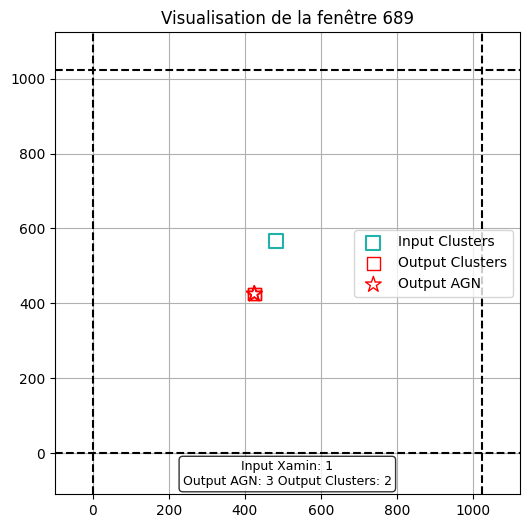

In [91]:
num_fenetre = random.randint(0, len(gen_seq)-1)

print(X_test[num_fenetre])
print(gen_seq[num_fenetre])

plot_sequence(gen_seq[num_fenetre], num_fenetre)

In [96]:
num_fenetre = random.randint(0, len(gen_seq)-1)

print(X_test[num_fenetre])
print(gen_seq[num_fenetre])

indice_debut_AMAS = len(SELECTED_COLUMNS_Xamin) * MAX_SOURCES + 2
indice_fin_AMAS   = len(SELECTED_COLUMNS_Xamin) * MAX_SOURCES + len(SELECTED_COLUMNS_input_clusters) * MAX_CLUSTERS +1

print("\n\033[1mCatalogue AMAS:\033[0m")
print(X_test[num_fenetre,indice_debut_AMAS:indice_fin_AMAS+1])

indice_debut_AGN = len(SELECTED_COLUMNS_Xamin) * MAX_SOURCES + len(SELECTED_COLUMNS_input_clusters) * MAX_CLUSTERS + 3 
indice_fin_AGN   = len(SELECTED_COLUMNS_Xamin) * MAX_SOURCES + len(SELECTED_COLUMNS_input_clusters) * MAX_CLUSTERS + len(SELECTED_COLUMNS_input_AGN) * MAX_AGN + 2

print("\n\033[1mCatalogue AGN:\033[0m")
print(X_test[num_fenetre,indice_debut_AGN:indice_fin_AGN+1])

print("\n\033[1mCatalogue AMAS extrait par la fonction:\033[0m")
print(gen_seq[num_fenetre,indice_debut_AMAS:indice_fin_AMAS+1])

print("\n\033[1mCatalogue AGN extrait par la fonction:\033[0m")
print(gen_seq[num_fenetre,indice_debut_AGN:indice_fin_AGN+1])


[1026  616  558  503  518  295 1024 1024 1024 1024 1024 1027  309  580
 1024 1024 1028  496  510 1024 1024 1024 1024 1025]
[1026  616  558  503  518  295 1024 1024 1024 1024 1024 1027  431  400
 1024 1024 1028  431  431  431  431  431  431 1025]

Catalogue AMAS:
[ 309  580 1024 1024]

Catalogue AGN:
[ 496  510 1024 1024 1024 1024]

Catalogue AMAS extrait par la fonction:
[ 431  400 1024 1024]

Catalogue AGN extrait par la fonction:
[431 431 431 431 431 431]
